<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2021/blob/master/08-ensembles/Ensembles_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


dataset = fetch_california_housing()

data = pd.DataFrame(dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

print(len(data))
data.head(10)

20640


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
5,4.0368,52.0,4.761658,1.103627,413.0,2.139896,37.85,-122.25,2.697
6,3.6591,52.0,4.931907,0.951362,1094.0,2.128405,37.84,-122.25,2.992
7,3.1200,52.0,4.797527,1.061824,1157.0,1.788253,37.84,-122.25,2.414
8,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,2.267
9,3.6912,52.0,4.970588,0.990196,1551.0,2.172269,37.84,-122.25,2.611


In [2]:
print(dataset.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

This data contains 2 spacial features: `['Longitude', 'Latitude']`:

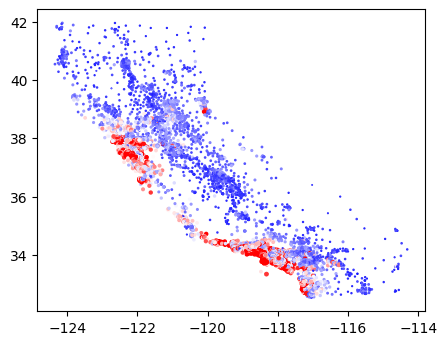

In [3]:
plt.figure(figsize=(5, 4), dpi=100)
plt.scatter(data.Longitude, data.Latitude, s=data.target, c=data.target, cmap='bwr');

(Compare this plot with the map of California: https://en.wikipedia.org/wiki/California)

A kNN model might be quite reasonable to use on this 2D subspace.

Let's first divide our data into train and test:

In [4]:
X, y = data.drop('target', axis=1), data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1234)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(15480, 8) (5160, 8) (15480,) (5160,)


 - Build a kNN regressor on the `Longitude` and `Latitude` features (**0.5 point**)
 - Build a random forest regressor on the rest of the features (**0.5 point**)
 - Build a stacking regressor (`sklearn.ensemble.StackingRegressor`) with 5-fold cross-val-predict using the two models above as the base models and a linear regression model as the final (aggregating) estimator. Don't forget to optimize hyper-parameters of your models. (**4 points**)
 - Compare the test MSE losses of the 3 models above, leave a comment (**1 point**)
 

Make sure to have a look at the documentation: 
https://scikit-learn.org/stable/modules/ensemble.html#stacking

You can make a pipeline (`sklearn.pipeline.make_pipeline`) with a `ColumnTransformer` (`sklearn.compose.make_column_transformer`) and a regression model (knn or random forest), where the `ColumnTransformer` will select the desired columns from the dataset (see the docs for the column transformer: https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html).

In [5]:
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

In [6]:
geocolumns_columns = [
    "Longitude",
    "Latitude"
]

other_columns = [
    "MedInc",   
    "HouseAge",
    "AveRooms",
    "AveBedrms",
    "Population",
    "AveOccup"   
]

In [7]:
X_train[geocolumns_columns]

,Longitude,Latitude
9101,-117.93,34.57
16450,-121.28,38.14
10247,-117.86,33.89
664,-122.14,37.70
3198,-119.65,36.37
...,...,...
8222,-118.23,33.76
9449,-119.85,37.39
8471,-118.32,33.91
17048,-122.27,37.47


In [9]:
import optuna

In [10]:
def knn_objective(trial):
    # define the grid
    param = {
        # number of nieghbors
        "n_neighbors": trial.suggest_int("n_neighbors", 2, 30),
        "weights": trial.suggest_categorical("weights", ["uniform", "distance"]),
        "algorithm":trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"]),
        "leaf_size": trial.suggest_int("leaf_size", 30, 50)
    }

    knn = KNeighborsRegressor()
    knn.set_params(**param)
    knn.fit(X_train[geocolumns_columns], y_train)
    preds = knn.predict(X_test[geocolumns_columns])
    # objective should return the metrics that you want to optimize
    MSE = mean_squared_error(y_test, preds)
    return MSE

In [11]:
study_knn = optuna.create_study(direction="minimize")
study_knn.optimize(knn_objective, n_trials=30, timeout=600)

[I 2023-12-02 22:43:53,864] A new study created in memory with name: no-name-19cc954a-d247-49e6-8a93-8663ce33484f
[I 2023-12-02 22:43:54,035] Trial 0 finished with value: 0.3487318731961058 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'algorithm': 'ball_tree', 'leaf_size': 37}. Best is trial 0 with value: 0.3487318731961058.
[I 2023-12-02 22:43:54,084] Trial 1 finished with value: 0.29564956982072493 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 43}. Best is trial 1 with value: 0.29564956982072493.
[I 2023-12-02 22:43:54,791] Trial 2 finished with value: 0.3354169349983735 and parameters: {'n_neighbors': 17, 'weights': 'uniform', 'algorithm': 'brute', 'leaf_size': 30}. Best is trial 1 with value: 0.29564956982072493.
[I 2023-12-02 22:43:54,975] Trial 3 finished with value: 0.33901783924897205 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'algorithm': 'ball_tree', 'leaf_size': 49}. Best is trial 1 with value: 0.29564

In [12]:
print("Best value: {}".format(study_knn.best_trial.value))
print("Best parameter: {}".format(study_knn.best_params))

  Best value: 0.29468438063239716
  Best parameter: {'n_neighbors': 6, 'weights': 'uniform', 'algorithm': 'kd_tree', 'leaf_size': 42}


In [13]:
knn = KNeighborsRegressor()
knn.fit(X_train[geocolumns_columns], y_train)
preds = knn.predict(X_test[geocolumns_columns])
MSE = mean_squared_error(y_test, preds)
print (MSE)

0.29681537252252554


In [14]:
def RFR_objective(trial):
    # define the grid
    param = {
        # number of nieghbors
        "n_estimators": trial.suggest_int("n_estimators", 50, 2000),
        "max_features": trial.suggest_categorical("max_features", ["auto", "sqrt","log2"]),
        "max_depth": trial.suggest_int("max_depth", 10, 100),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
    }
    rfr = RandomForestRegressor()
    rfr.set_params(**param)


    rfr.fit(X_train[other_columns], y_train)
    preds = rfr.predict(X_test[other_columns])
    MSE = mean_squared_error(y_test, preds)
    return MSE

In [15]:
study_rfr = optuna.create_study(direction="minimize")
study_rfr.optimize(RFR_objective, n_trials=10, timeout=600)

[I 2023-12-02 22:56:45,230] A new study created in memory with name: no-name-731796f9-f1d0-4fa9-a89f-125de5ef2129
[I 2023-12-02 22:57:37,683] Trial 0 finished with value: 0.4227968040975798 and parameters: {'n_estimators': 804, 'max_features': 'sqrt', 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 2, 'bootstrap': True}. Best is trial 0 with value: 0.4227968040975798.
[I 2023-12-02 22:57:48,849] Trial 1 finished with value: 0.4267292438375638 and parameters: {'n_estimators': 208, 'max_features': 'log2', 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.4227968040975798.
[I 2023-12-02 22:59:19,281] Trial 2 finished with value: 0.42614889950250523 and parameters: {'n_estimators': 1540, 'max_features': 'log2', 'max_depth': 75, 'min_samples_split': 5, 'min_samples_leaf': 6, 'bootstrap': True}. Best is trial 0 with value: 0.4227968040975798.
[I 2023-12-02 23:00:21,374] Trial 3 finished with value: 0.425574050121117

In [16]:
print("Best value: {}".format(study_rfr.best_trial.value))
print("Best parameter: {}".format(study_rfr.best_params))

Best value: 0.4225516545135376
Best parameter: {'n_estimators': 707, 'max_features': 'sqrt', 'max_depth': 34, 'min_samples_split': 5, 'min_samples_leaf': 1, 'bootstrap': True}


In [17]:
rfr = RandomForestRegressor()
rfr.fit(X_train[other_columns], y_train)
preds = rfr.predict(X_test[other_columns])
MSE = mean_squared_error(y_test, preds)
print (MSE)

0.43086433103794236


In [18]:
geo_selector = make_column_transformer(
    ('passthrough', geocolumns_columns),
    remainder = 'drop')

In [19]:
other_selector = make_column_transformer(
    ('drop', geocolumns_columns),
    remainder = 'passthrough')

In [20]:
kn = KNeighborsRegressor()
kn.set_params(**study_knn.best_params)
geo_pipeline = make_pipeline(geo_selector ,kn)

In [21]:
rfr =RandomForestRegressor()
rfr.set_params(**study_rfr.best_params)
other_pipeline = make_pipeline(other_selector ,rfr)

In [22]:
estimators = [
('knn',geo_pipeline ),
('rfr', other_pipeline)
]

In [23]:
SR = StackingRegressor(
estimators=estimators,
final_estimator=LinearRegression(),
cv =  5
)

In [24]:
from sklearn import set_config
set_config(display="diagram")

In [25]:
SR.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('knn',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(transformers=[('passthrough',
                                                                                 'passthrough',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(algorithm='kd_tree',
                                                                    leaf_size=42,
                                                                    n_neighbors=6))])),
                              ('rfr',
                               Pipeline(steps=[('columntransformer',
                                                ColumnTransformer(remainder='passthrough',
                                                                  transformers=[('drop',
                                                                                 'drop',
                                                                                 ['Longitude',
                                                                                  'Latitude'])])),
                                               ('randomforestregressor',
                                                RandomForestRegressor(max_depth=34,
                                                                      max_features='sqrt',
                                                                      min_samples_split=5,
                                                                      n_estimators=707))]))],
                  final_estimator=LinearRegression())

In [26]:
preds = SR.predict(X_test)

In [27]:
MSE = mean_squared_error(y_test, preds)
print (MSE)

0.22862768615865747


The study reveals that through meticulous hyperparameter optimization for both K-Nearest Neighbors (KNR) and Random Forest Regressor (RFR) models, coupled with the implementation of a Stacking Regressor, notable improvements in Mean Squared Error (MSE) have been achieved.

An intriguing finding from the analysis is the pronounced significance of the "Longitude" and "Latitude" features among the eight features in the input dataset. This is evident from the close MSE values obtained for the optimized KNR and the optimized Stacking Regressor (0.29 for KNR and 0.22 for SR). Notably, a substantial disparity in MSE values exists between the optimized RFR and SR (0.43 for RFR compared to 0.22 for SR).

The conclusion drawn is that the ensemble of the two models in a Stacking Regressor configuration yields a superior MSE, capitalizing on the robustness of KNR when applied specifically to the "Longitude" and "Latitude" features. This approach avoids the need to discard the remaining features or include them in the KNR learning process, as their inclusion might alter the learning dynamics of KNR.